Problema 2

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.diagnostic as smd
import statsmodels.stats.outliers_influence as smo


In [2]:
# Carregar o arquivo .dta
df = pd.read_stata("Base1.dta")

# Exibir as primeiras linhas
print(df.head())

# Exibir informações gerais da base
print(df.info())

# Calcular as estatísticas descritivas
print(df.describe())


   TIME    ID  MALE   AGE     S  ETHBLACK  ETHHISP  HEIGHT85  WEIGHT  ASVAB02  \
0   0.0   2.0   0.0  21.0   9.0       0.0      0.0      62.0     NaN     36.0   
1   0.0   3.0   0.0  18.0  10.0       0.0      0.0      70.0     NaN     43.0   
2   0.0  17.0   1.0  23.0  13.0       0.0      0.0      69.0     NaN     65.0   
3   0.0  18.0   1.0  22.0  12.0       0.0      0.0      66.0     NaN     66.0   
4   0.0  24.0   1.0  19.0  12.0       0.0      0.0      72.0     NaN     55.0   

   ...  REGS   EARNINGS  HOURS    TENURE       EXP  CLASSPRI  CLASSGOV  \
0  ...   0.0   8.701859   35.0  1.826923  1.019231       1.0       0.0   
1  ...   0.0   7.559383   37.0  0.134615  1.057692       1.0       0.0   
2  ...   0.0  11.139143   46.0  2.134615  0.942308       1.0       0.0   
3  ...   0.0   7.921167   48.0  0.673077  0.711538       1.0       0.0   
4  ...   0.0   8.092539   40.0  0.269231  0.576923       1.0       0.0   

   CLASSSE  UNION  UNCOLB  
0      0.0    NaN     0.0  
1      0.0  

Regressão Pooled OLS com variáveis de controle:
                            OLS Regression Results                            
Dep. Variable:               EARNINGS   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     1202.
Date:                Thu, 06 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:23:51   Log-Likelihood:                -85530.
No. Observations:               24508   AIC:                         1.711e+05
Df Residuals:                   24501   BIC:                         1.711e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

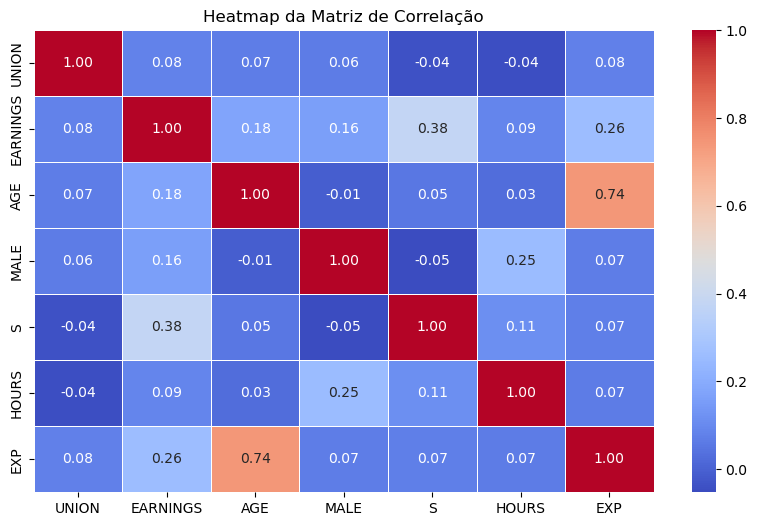


Testes de Hipóteses para o modelo Pooled OLS:
Teste de Breusch-Pagan (Heterocedasticidade): p-valor = 6.1129169034946934e-30
Rejeitamos H0: Existe heterocedasticidade nos resíduos.

Fatores de Inflação da Variância (VIF):
  Variável         VIF
0    const  119.405376
1    UNION    1.015519
2      AGE    2.241932
3     MALE    1.092196
4        S    1.025957
5    HOURS    1.092105
6      EXP    2.264024
Existe forte multicolinearidade entre as variáveis.

Teste de Jarque-Bera (Normalidade dos resíduos): p-valor = 0.0
Rejeitamos H0: Os resíduos não seguem uma distribuição normal.

Teste de Durbin-Watson (Autocorrelação dos resíduos): Estatística = 1.056909406305443
Possível presença de autocorrelação nos resíduos.


In [8]:
# Filtrar valores ausentes ou infinitos das variáveis relevantes
variables = ["ID", "UNION", "EARNINGS", "AGE", "MALE", "S", "HOURS", "EXP", "TIME"]
df = df.dropna(subset=variables)
df = df[~df[variables].isin([float("inf"), float("-inf")]).any(axis=1)]

# Agrupar por tempo e por pessoa (ID) e calcular a média
df = df.groupby(["ID", "TIME"]).mean().reset_index()

# Verificar se há registros suficientes para a regressão
if len(df) > 1:
    # Preparar os dados para a regressão
    X = df[["UNION", "AGE", "MALE", "S", "HOURS", "EXP"]]  # Variáveis explicativas
    y = df["EARNINGS"]  # Variável dependente
    
    # Adicionar uma constante (intercepto) ao modelo
    X = sm.add_constant(X)
    
    # Ajustar o modelo de regressão
    model_pooled = sm.OLS(y, X).fit()
    
    # Exibir o resumo da regressão empilhada
    print("Regressão Pooled OLS com variáveis de controle:")
    print(model_pooled.summary())
    
    # Calcular a matriz de correlação
    correlation_matrix = df[["UNION", "EARNINGS", "AGE", "MALE", "S", "HOURS", "EXP"]].corr()
    print("Matriz de correlação:")
    print(correlation_matrix)
    
    # Plotar o heatmap da correlação
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Heatmap da Matriz de Correlação")
    plt.show()
    
    # Testes de hipóteses para validação do modelo Pooled OLS
    print("\nTestes de Hipóteses para o modelo Pooled OLS:")
    
    # Teste de heterocedasticidade de Breusch-Pagan
    bp_test = smd.het_breuschpagan(model_pooled.resid, X)
    print(f"Teste de Breusch-Pagan (Heterocedasticidade): p-valor = {bp_test[1]}")
    if bp_test[1] < 0.05:
        print("Rejeitamos H0: Existe heterocedasticidade nos resíduos.")
    else:
        print("Não rejeitamos H0: Os resíduos são homocedásticos.")
    
    # Teste de multicolinearidade (VIF - Variance Inflation Factor)
    vif_data = pd.DataFrame()
    vif_data["Variável"] = X.columns
    vif_data["VIF"] = [smo.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nFatores de Inflação da Variância (VIF):")
    print(vif_data)
    if vif_data["VIF"].max() > 10:
        print("Existe forte multicolinearidade entre as variáveis.")
    else:
        print("Os valores de VIF indicam ausência de multicolinearidade significativa.")
    
    # Teste de normalidade dos resíduos (Jarque-Bera)
    jb_test = sm.stats.jarque_bera(model_pooled.resid)
    print(f"\nTeste de Jarque-Bera (Normalidade dos resíduos): p-valor = {jb_test[1]}")
    if jb_test[1] < 0.05:
        print("Rejeitamos H0: Os resíduos não seguem uma distribuição normal.")
    else:
        print("Não rejeitamos H0: Os resíduos seguem uma distribuição normal.")
    
    # Teste de autocorrelação dos resíduos (Durbin-Watson)
    dw_test = sm.stats.durbin_watson(model_pooled.resid)
    print(f"\nTeste de Durbin-Watson (Autocorrelação dos resíduos): Estatística = {dw_test}")
    if dw_test < 1.5 or dw_test > 2.5:
        print("Possível presença de autocorrelação nos resíduos.")
    else:
        print("Os resíduos não apresentam evidências de autocorrelação.")
else:
    print("Não há registros suficientes para a regressão Pooled OLS.")
